# Model on trained with ADABOOST


# Setting up the environment


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

RSEED = 45

In [20]:
# import the file
df_baseline = pd.read_csv('data/kickstarter_modeling.csv')
df_baseline.head()


,funding_goal,outcome,funding_period,launch_year,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film & Video,...,country_Mexico,country_Netherlands,country_New Zealand,country_Norway,country_Singapore,country_Spain,country_Sweden,country_Switzerland,country_United Kingdom,country_United States
0,1000,0,39,2009,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,80000,0,87,2009,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,20,1,8,2009,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,99,1,79,2009,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1900,0,28,2009,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [53]:
df_baseline.launch_year.value_counts()

launch_year
2015    65272
2014    59305
2016    49096
2017    43419
2013    41088
2012    38478
2011    24048
2010     9577
2009     1179
Name: count, dtype: int64

In [21]:
""" HELPER FUNCTION: GET ERROR RATE ========================================="""
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

""" HELPER FUNCTION: PRINT ERROR RATE ======================================="""
def print_error_rate(err):
    print ('Error rate: Training: %.4f - Test: %.4f' % err)

""" HELPER FUNCTION: GENERIC CLASSIFIER ====================================="""
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [22]:
""" ADABOOST IMPLEMENTATION ================================================="""
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # 
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # 
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # 
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # 
        miss2 = [x if x==1 else -1 for x in miss]
        # 
        err_m = np.dot(w,miss) / sum(w)
        # 
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # 
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        # 
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # 
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [23]:

""" PLOT FUNCTION ==========================================================="""
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')



/var/folders/1v/ndy1hbg96c1gd0g5n5lhmcw80000gn/T/ipykernel_33623/3828118058.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot1.set_xticklabels(range(0,450,50))


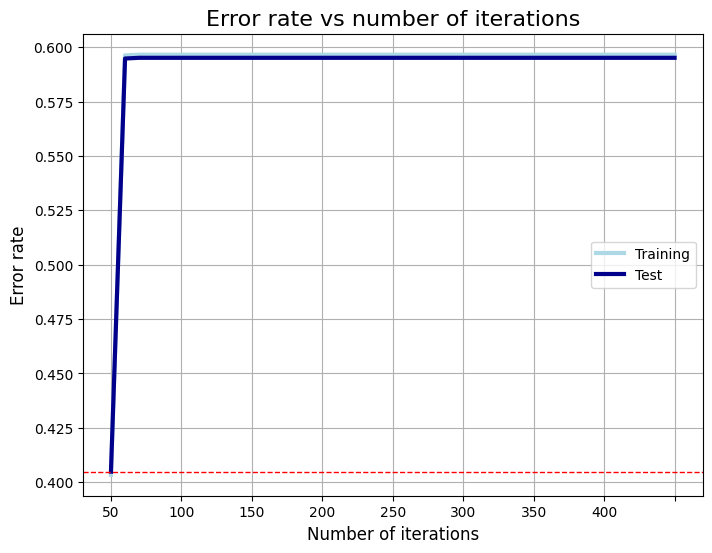

In [24]:
""" MAIN SCRIPT ============================================================="""
if __name__ == '__main__':
    
    # Read data
    X = df_baseline.drop('outcome', axis=1)
    y = df_baseline['outcome']

    # Split into training and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, random_state=RSEED)
    
    # Fit a simple decision tree first
    clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
    er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
    
    # Fit Adaboost classifier using a decision tree as base estimator
    # Test with different number of iterations
    er_train, er_test = [er_tree[0]], [er_tree[1]]
    x_range = range(10, 410, 10)
    for i in x_range:    
        er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
        er_train.append(er_i[0])
        er_test.append(er_i[1])
    
    # Compare error rate vs number of iterations
    plot_error_rate(er_train, er_test)

In [35]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=RSEED)

# Fit the AdaBoost classifier
adaboost_clf.fit(X_train, Y_train)

# Make predictions
y_pred_train = adaboost_clf.predict(X_train)
y_pred_test = adaboost_clf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(Y_train, y_pred_train)
test_accuracy = accuracy_score(Y_test, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

train_precision = precision_score(Y_train, y_pred_train)
test_precision = precision_score(Y_test, y_pred_test)

print("Training Precision:", train_precision)
print("Test Precision:", test_precision)

Training Accuracy: 0.6816079100226874
Test Accuracy: 0.6815219752371299
Training Precision: 0.6298615972196637
Test Precision: 0.6319669713948688


In [40]:
from sklearn.preprocessing import MinMaxScaler
columns_to_normalize = ['funding_goal', 'funding_period', 'launch_year']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it for the selected columns
X_train_normalized = X_train.copy()  # Make a copy of the training data
X_train_normalized[columns_to_normalize] = scaler.fit_transform(X_train_normalized[columns_to_normalize])

# Transform the test data using the same scaler and for the selected columns
X_test_normalized = X_test.copy()  # Make a copy of the test data
X_test_normalized[columns_to_normalize] = scaler.transform(X_test_normalized[columns_to_normalize])

In [41]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_clf_norm = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=RSEED)

# Fit the AdaBoost classifier
adaboost_clf_norm.fit(X_train_normalized, Y_train)

# Make predictions
y_pred_train_norm = adaboost_clf.predict(X_train_normalized)
y_pred_test_norm = adaboost_clf.predict(X_test_normalized)

# Calculate accuracy
train_accuracy_norm = accuracy_score(Y_train, y_pred_train_norm)
test_accuracy_norm = accuracy_score(Y_test, y_pred_test_norm)

print("Training Accuracy:", train_accuracy_norm)
print("Test Accuracy:", test_accuracy_norm)

train_precision_norm = precision_score(Y_train, y_pred_train_norm)
test_precision_norm = precision_score(Y_test, y_pred_test_norm)

print("Training Precision:", train_precision_norm)
print("Test Precision:", test_precision_norm)

Training Accuracy: 0.4123879708442614
Test Accuracy: 0.413595443245722
Training Precision: 0.40697419223735015
Test Precision: 0.40831403145190787


In [42]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
stdscaler = StandardScaler()

# Fit the scaler on the training data and transform it for the selected columns
X_train_standardized = X_train.copy()  # Make a copy of the training data
X_train_standardized[columns_to_normalize] = stdscaler.fit_transform(X_train_standardized[columns_to_normalize])

# Transform the test data using the same scaler and for the selected columns
X_test_standardized = X_test.copy()  # Make a copy of the test data
X_test_standardized[columns_to_normalize] = stdscaler.transform(X_test_standardized[columns_to_normalize])

In [43]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_clf_std = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=RSEED)

# Fit the AdaBoost classifier
adaboost_clf_std.fit(X_train_standardized, Y_train)

# Make predictions
y_pred_train_std = adaboost_clf.predict(X_train_standardized)
y_pred_test_std = adaboost_clf.predict(X_test_standardized)

# Calculate accuracy
train_accuracy_std = accuracy_score(Y_train, y_pred_train_std)
test_accuracy_std = accuracy_score(Y_test, y_pred_test_std)

print("Training Accuracy:", train_accuracy_std)
print("Test Accuracy:", test_accuracy_std)

train_precision_std = precision_score(Y_train, y_pred_train_std)
test_precision_std = precision_score(Y_test, y_pred_test_std)

print("Training Precision:", train_precision_std)
print("Test Precision:", test_precision_std)

Training Accuracy: 0.4124523322981866
Test Accuracy: 0.41364371394781935
Training Precision: 0.4070006584455807
Test Precision: 0.4083339428961549


In [49]:
from sklearn.model_selection import GridSearchCV

# Initialize base estimator (weak learner)
estimator = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost classifier
adaboost_clf_gs = AdaBoostClassifier(estimator=estimator, random_state=RSEED)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [150, 140],
    'learning_rate': [0.01, 0.005, 0.0075]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(adaboost_clf_gs, param_grid, cv=5, scoring='precision')

# Fit GridSearchCV to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Make predictions with the best estimator
y_pred_train = grid_search.best_estimator_.predict(X_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)

# Calculate precision
train_precision = precision_score(Y_train, y_pred_train, zero_division='warn')
test_precision = precision_score(Y_test, y_pred_test, zero_division='warn')

print("Training Precision:", train_precision)
print("Test Precision:", test_precision)

/Users/lea/Documents/neueFische/project2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lea/Documents/neueFische/project2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lea/Documents/neueFische/project2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lea/Document

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 140}
Training Precision: 0.8819776714513556
Test Precision: 0.8276699029126213


In [50]:
acc_train = accuracy_score(y_pred_train, Y_train)
acc = accuracy_score(y_pred_test, Y_test)
print(f'Train accuracy is : {acc_train}')
print(f'Test accuracy is : {acc}')

print('---' * 17)

prec_train = precision_score(y_pred_train, Y_train)
prec = precision_score(y_pred_test, Y_test)
print(f'Train precision is : {prec_train}')
print(f'Test precision is : {prec}')

print('---' * 17)

reca_train = recall_score(y_pred_train, Y_train)
reca = recall_score(y_pred_test, Y_test)
print(f'Train recall is : {reca_train}')
print(f'Test recall is : {reca}')

print('---' * 17)

f1_train = f1_score(y_pred_train, Y_train)
f1 = f1_score(y_pred_test, Y_test)
print(f'Train f1 score is : {f1_train}')
print(f'Test f1 score is : {f1}')

print('---' * 17)

roc_train = roc_auc_score(y_pred_train, Y_train)
roc = roc_auc_score(y_pred_test, Y_test)
print(f'Train roc_auc is : {roc_train}')
print(f'Test roc_auc is : {roc}')

Train accuracy is : 0.6003877777598996
Test accuracy is : 0.5983756908744238
---------------------------------------------------
Train precision is : 0.01102691924227318
Test precision is : 0.010163631486393848
---------------------------------------------------
Train recall is : 0.8819776714513556
Test recall is : 0.8276699029126213
---------------------------------------------------
Train f1 score is : 0.021781515252968862
Test f1 score is : 0.020080676029797132
---------------------------------------------------
Train roc_auc is : 0.7404689078525305
Test roc_auc is : 0.7124499367814616


Best Parameters: {'learning_rate': 0.01, 'n_estimators': 150}
Training Precision: 0.8401420959147424
Test Precision: 0.7939068100358423

In [51]:
from sklearn.model_selection import GridSearchCV

# Initialize base estimator (weak learner)
estimator = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost classifier
adaboost_clf_gs_std = AdaBoostClassifier(estimator=estimator, random_state=RSEED)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(adaboost_clf_gs, param_grid, cv=5, scoring='precision')

# Fit GridSearchCV to the data
grid_search.fit(X_train_standardized, Y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Make predictions with the best estimator
y_pred_train = grid_search.best_estimator_.predict(X_train_standardized)
y_pred_test = grid_search.best_estimator_.predict(X_test_standardized)

# Calculate precision
train_precision = precision_score(Y_train, y_pred_train, zero_division='warn')
test_precision = precision_score(Y_test, y_pred_test, zero_division='warn')

print("Training Precision:", train_precision)
print("Test Precision:", test_precision)

/Users/lea/Documents/neueFische/project2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lea/Documents/neueFische/project2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lea/Documents/neueFische/project2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lea/Document

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 150}
Training Precision: 0.8401420959147424
Test Precision: 0.7939068100358423
